In [1]:
# works with ct files from RNAStralign and ArchiveII -------------------------- ! ! ! !
def straextractdot(db_file):
    
    with open(db_file, 'r') as file:
        lines = file.readlines()
    
    sequence = lines[1].rstrip('\n').upper()
    length = len(sequence)
    dot_bracket = lines[2].rstrip('\n')
    
    return length, sequence, dot_bracket

# works with dbn files from bpRNA-1m ----------------------------------------- ! ! ! !
def dbextractdot(db_file):
    
    with open(db_file, 'r') as file:
        lines = file.readlines()
    
    length = int(lines[1].split()[1].replace(",", ""))
    sequence = lines[3].rstrip('\n').upper()
    dot_bracket = lines[4].rstrip('\n')
    
    return length, sequence, dot_bracket

In [2]:
data = []
datacount = 0

for root, dirs, files in os.walk('./bpRNA_1m/'):
    for file in files:
        if file.endswith('.dbn'):
            datacount += 1
            dbn_file = os.path.join(root, file)
            length, sequence, dot_bracket = dbextractdot(dbn_file)
            sample = {'GeneralID': 'G'+str(datacount).zfill(6), 'Length': length , 'Sequence': sequence, 'S_structure': dot_bracket, 'Dataset':'bpRNA-1m' , 'InternalID': file }
            data.append(sample)

print('All done:',datacount,'instances enrolled!')

All done: 102318 instances enrolled!


In [3]:
data = []
datacount = 0

for root, dirs, files in os.walk('./RNAStrAlign/'):
    for file in files:
        if file.endswith('.dbn'):
            datacount += 1
            dbn_file = os.path.join(root, file)
            length, sequence, dot_bracket = straextractdot(dbn_file)
            sample = {'GeneralID': 'G'+str(datacount).zfill(6), 'Length': length , 'Sequence': sequence, 'S_structure': dot_bracket, 'Dataset':'RNAStralign' , 'InternalID': file }
            data.append(sample)

for root, dirs, files in os.walk('./ArchiveII/'):
    for file in files:
        if file.endswith('.dbn'):
            datacount += 1
            dbn_file = os.path.join(root, file)
            length, sequence, dot_bracket = straextractdot(dbn_file)
            sample = {'GeneralID': 'G'+str(datacount).zfill(6), 'Length': length , 'Sequence': sequence, 'S_structure': dot_bracket, 'Dataset':'ArchiveII' , 'InternalID': file }
            data.append(sample)

for root, dirs, files in os.walk('./bpRNA_1m/'):
    for file in files:
        if file.endswith('.dbn'):
            datacount += 1
            dbn_file = os.path.join(root, file)
            length, sequence, dot_bracket = dbextractdot(dbn_file)
            sample = {'GeneralID': 'G'+str(datacount).zfill(6), 'Length': length , 'Sequence': sequence, 'S_structure': dot_bracket, 'Dataset':'bpRNA-1m' , 'InternalID': file }
            data.append(sample)

print('All done:',datacount,'instances enrolled!')


All done: 143354 instances enrolled!


In [3]:
import json

with open("secstr.json", "w") as file:
    json.dump(data, file)

In [1]:
import json

with open("secstr.json", "r") as file:
    data = json.load(file)

In [13]:
from tqdm import tqdm

high_length = 1024
count = 0
for i in tqdm(data):
    if (i['Length'] > high_length) or (i['Length'] < 20):
        count += 1
print(f"Number of sequences with length above {high_length} (and underneath 10):", count)

#repeat until stabilize and count = 0 (dont know why..?)
for i in tqdm(data):
    if (i['Length'] > high_length) or (i['Length'] < 10):
        data.remove(i)
print("Number of sequences left in the dataset:", len(data))

100%|██████████| 119991/119991 [00:00<00:00, 4027647.58it/s]


Number of sequences with length above 1024 (and underneath 10): 1835


100%|██████████| 119991/119991 [00:00<00:00, 4499264.53it/s]

Number of sequences left in the dataset: 119991


In [14]:
from tqdm import tqdm

valid_chars = ['A', 'C', 'G', 'U']
invalid_sequences = []
count = 0
for i in tqdm(data):
    sequence = i['Sequence']
    if any(char not in valid_chars for char in sequence):
        count += 1
        invalid_sequences.append(i)

print("Number of sequences with invalid characters:", count)

for i in invalid_sequences:
    data.remove(i)

print("Number of sequences left in the dataset:", len(data))

100%|██████████| 119991/119991 [00:00<00:00, 141364.12it/s]


Number of sequences with invalid characters: 3893
Number of sequences left in the dataset: 116098


In [15]:
codes = []
for rna in data:
    if (rna['Dataset'] == 'ArchiveII') or (rna['Dataset'] == 'RNAStralign'):
        for char in rna['S_structure']:
            if char in ['{', '}']:
                if rna['GeneralID'] not in codes:
                    codes.append(rna['GeneralID'])
for rna in data:
    if rna['GeneralID'] in codes:
        data.remove(rna)
        
print(len(data))

116093


In [16]:
# keep conventional dot-bracket: ., (, ), [, ], and remove level 2+ pseudoknots from bpRNA-1m 
from tqdm import tqdm

to_remove = []

for rna in tqdm(data):
    if (rna['Dataset'] == 'RNAStralign') or (rna['Dataset'] == 'ArchiveII'):
        rna['S_structure'] = rna['S_structure'].replace('<', '[').replace('>', ']')
    elif rna['Dataset'] == 'bpRNA-1m':
        for char in rna['S_structure']:
            if char not in ['.', '(', ')', '[', ']']:
                if rna['GeneralID'] not in to_remove:
                    to_remove.append(rna['GeneralID'])
for rna in data:
    if rna['GeneralID'] in to_remove:
        data.remove(rna)

print(len(data))

100%|██████████| 116093/116093 [00:00<00:00, 237565.44it/s]


115692


In [17]:
import json

with open("secstr_1024_clean.json", "w") as file:
    json.dump(data, file)

In [18]:
import json

with open('./secstr_1024_clean.json', 'r') as file:
    data = json.load(file)

In [2]:
import json

with open('../AvailableRNA/891.json', 'r') as file:
    data = json.load(file)

In [21]:
import subprocess
import json
import random

def cluster_rna_sequences(json_file, threshold):
    # Read the JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Prepare the input file for CD-HIT
    sequences_file = 'sequences.fasta'
    with open(sequences_file, 'w') as file:
        for entry in data:
            sequence = entry['Sequence']
            external_id = entry['GeneralID']
            file.write(f'>{external_id}\n{sequence}\n')

    # Run CD-HIT to cluster the RNA sequences
    output_file = 'cdhit_output'
    """
   -i	input filename in fasta format, required, can be in .gz format
   -j	input filename in fasta/fastq format for R2 reads if input are paired end (PE) files
 	 -i R1.fq -j R2.fq -o output_R1 -op output_R2 or
 	 -i R1.fa -j R2.fa -o output_R1 -op output_R2 
   -o	output filename, required
   -op	output filename for R2 reads if input are paired end (PE) files
   -c	sequence identity threshold, default 0.9
 	this is the default cd-hit's "global sequence identity" calculated as:
 	number of identical amino acids or bases in alignment
 	divided by the full length of the shorter sequence
   -G	use global sequence identity, default 1
 	if set to 0, then use local sequence identity, calculated as :
 	number of identical amino acids or bases in alignment
 	divided by the length of the alignment
 	NOTE!!! don't use -G 0 unless you use alignment coverage controls
 	see options -aL, -AL, -aS, -AS
   -b	band_width of alignment, default 20
   -M	memory limit (in MB) for the program, default 800; 0 for unlimitted;
   -T	number of threads, default 1; with 0, all CPUs will be used
   -n	word_length, default 10, see user's guide for choosing it
   -l	length of throw_away_sequences, default 10
   -d	length of description in .clstr file, default 20
 	if set to 0, it takes the fasta defline and stops at first space
   -s	length difference cutoff, default 0.0
 	if set to 0.9, the shorter sequences need to be
 	at least 90% length of the representative of the cluster
   -S	length difference cutoff in amino acid, default 999999
 	if set to 60, the length difference between the shorter sequences
 	and the representative of the cluster can not be bigger than 60
   -aL	alignment coverage for the longer sequence, default 0.0
 	if set to 0.9, the alignment must covers 90% of the sequence
   -AL	alignment coverage control for the longer sequence, default 99999999
 	if set to 60, and the length of the sequence is 400,
 	then the alignment must be >= 340 (400-60) residues
   -aS	alignment coverage for the shorter sequence, default 0.0
 	if set to 0.9, the alignment must covers 90% of the sequence
   -AS	alignment coverage control for the shorter sequence, default 99999999
 	if set to 60, and the length of the sequence is 400,
 	then the alignment must be >= 340 (400-60) residues
   -A	minimal alignment coverage control for the both sequences, default 0
 	alignment must cover >= this value for both sequences 
   -uL	maximum unmatched percentage for the longer sequence, default 1.0
 	if set to 0.1, the unmatched region (excluding leading and tailing gaps)
 	must not be more than 10% of the sequence
   -uS	maximum unmatched percentage for the shorter sequence, default 1.0
 	if set to 0.1, the unmatched region (excluding leading and tailing gaps)
 	must not be more than 10% of the sequence
   -U	maximum unmatched length, default 99999999
 	if set to 10, the unmatched region (excluding leading and tailing gaps)
 	must not be more than 10 bases
   -B	1 or 0, default 0, by default, sequences are stored in RAM
 	if set to 1, sequence are stored on hard drive
 	!! No longer supported !!
   -P	input paired end (PE) reads, default 0, single file
 	if set to 1, please use -i R1 -j R2 to input both PE files
   -cx	length to keep after trimming the tail of sequence, default 0, not trimming
 	if set to 50, the program only uses the first 50 letters of input sequence
   -cy	length to keep after trimming the tail of R2 sequence, default 0, not trimming
 	if set to 50, the program only uses the first 50 letters of input R2 sequence
 	e.g. -cx 100 -cy 80 for paired end reads
   -ap	alignment position constrains,  default 0, no constrain
 	if set to 1, the program will force sequences to align at beginings
 	when set to 1, the program only does +/+ alignment
   -p	1 or 0, default 0
 	if set to 1, print alignment overlap in .clstr file
   -g	1 or 0, default 0
 	by cd-hit's default algorithm, a sequence is clustered to the first 
 	cluster that meet the threshold (fast cluster). If set to 1, the program
 	will cluster it into the most similar cluster that meet the threshold
 	(accurate but slow mode)
 	but either 1 or 0 won't change the representatives of final clusters
   -r	1 or 0, default 1, by default do both +/+ & +/- alignments
 	if set to 0, only +/+ strand alignment
   -mask	masking letters (e.g. -mask NX, to mask out both 'N' and 'X')
   -match	matching score, default 2 (1 for T-U and N-N)
   -mismatch	mismatching score, default -2
   -gap	gap opening score, default -6
   -gap-ext	gap extension score, default -1
   -bak	write backup cluster file (1 or 0, default 0)
   -sc	sort clusters by size (number of sequences), default 0, output clusters by decreasing length
 	if set to 1, output clusters by decreasing size
   -sf	sort fasta/fastq by cluster size (number of sequences), default 0, no sorting
 	if set to 1, output sequences by decreasing cluster size
 	this can be very slow if the input is in .gz format
   -h	print this help

    """
    command = f'cd-hit-est -i {sequences_file} -o {output_file} -c {threshold} -g 1 -l 9 -s 1 -p 1 -T 0 '
    subprocess.run(command, shell=True)

    # Parse the CD-HIT output file to extract representative sequences
    cluster_ids = ['delete..']
    representatives = []
    with open(output_file + '.clstr', 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('>Cluster'):
                    representatives.append(random.choice(cluster_ids))  # Rnadom sequence in the cluster is the representative (varriety of lengths)
                    cluster_ids = []
                else:
                    cluster_ids.append(line.split()[2].lstrip('>').rstrip('...'))

    return representatives


In [22]:
json_file = './secstr_1024_clean.json'
threshold = 0.80
representatives = cluster_rna_sequences(json_file, threshold)

print("Representative sequences:",len(representatives))

Program: CD-HIT, V4.8.1, Mar 10 2023, 15:20:40
Command: cd-hit-est -i sequences.fasta -o cdhit_output -c 0.8
         -g 1 -l 9 -s 1 -p 1 -T 0

Started: Mon Jun 10 15:07:45 2024
                            Output                              
----------------------------------------------------------------
Option -T is ignored: multi-threading with OpenMP is NOT enabled!
total seq: 115692
longest and shortest : 1024 and 10
Total letters: 16476699
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 30M
Buffer          : 1 X 13M = 13M
Table           : 1 X 18M = 18M
Miscellaneous   : 5M
Total           : 68M

Table limit with the given memory limit:
Max number of representatives: 2718939
Max number of word counting entries: 91432496

comparing sequences from          0  to     115692
..........    10000  finished       3331  clusters
..........    20000  finished       8175  clusters
..........    30000  finished      11917  clusters
..........    40000

In [23]:
len(representatives)

30256

In [24]:
with open('./secstr_1024_clean.json', 'r') as file:
    data = json.load(file)

In [33]:
from tqdm import tqdm
print('Number of representatives in dataset:', len(representatives), '\nLeft in dataset shoud be:', len(representatives)-1)

# Keep repeating till result (-1) is reached .. (RAM needs)
for i in tqdm(data):
    if i['GeneralID'] not in representatives:
        data.remove(i)

print('Number of sequences left in dataset:', len(data))

Number of representatives in dataset: 30256 
Left in dataset shoud be: 30255


100%|██████████| 30255/30255 [00:05<00:00, 5815.36it/s]

Number of sequences left in dataset: 30255


In [34]:
with open("2D_1024.json", "w") as file:
    json.dump(data, file)

DATASET PROPERTIES

In [4]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

def plotlengths(jsonfile, title):
    with open(jsonfile, 'r') as file:
        data = json.load(file)

    lengths = [entry['Length'] for entry in data]
    sns.histplot(x=lengths, color='black', bins=100)
    plt.xlabel('Sequence length')
    plt.title(str(title))
    plt.show()

def plotdbs(jsonfile, title):
    with open(jsonfile, 'r') as file:
        data = json.load(file)

    dbs = [entry['Dataset'] for entry in data]
    counts = {}
    for db in dbs:
        counts[db] = counts.get(db, 0) + 1

    plt.figure(figsize=(5, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), color='black')
    plt.xlabel('Datasets')
    plt.ylabel('Count')
    plt.title(title)

    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust spacing to prevent label cutoff
    plt.show()

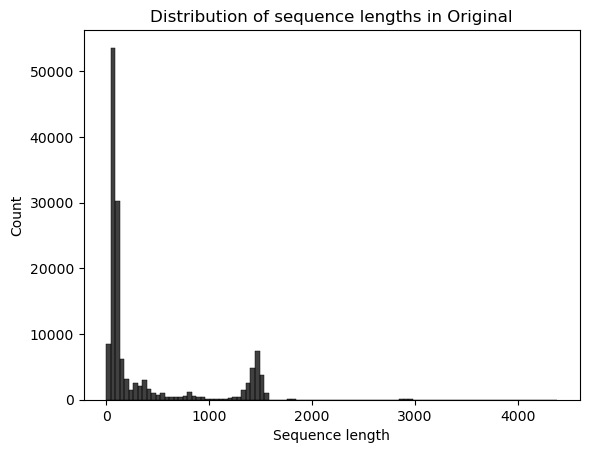

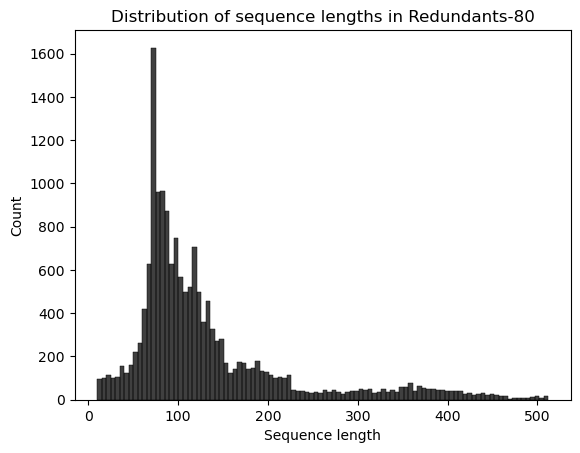

In [7]:
plotlengths('secstr.json', 'Distribution of sequence lengths in Original')
plotlengths('redundants80_for_dnabert.json', 'Distribution of sequence lengths in Redundants-80')

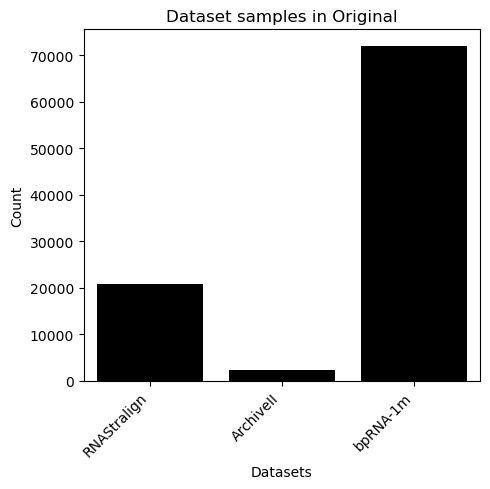

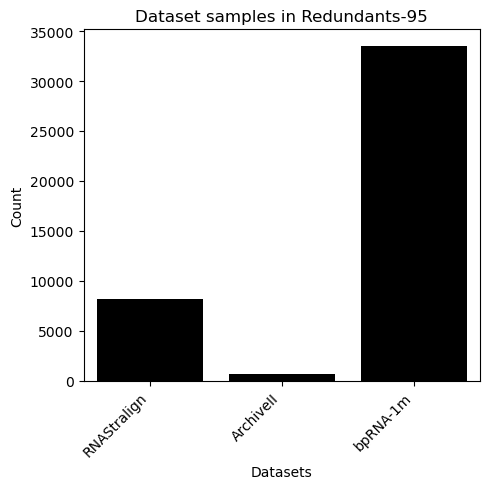

In [179]:
plotdbs('secstr_clean.json', 'Dataset samples in Original')
plotdbs('redundants95.json', 'Dataset samples in Redundants-95')

DELETE INDIPEDENT TEST SET

In [9]:
import subprocess
import json
import random

def find_testset(json_file, query_file, threshold):
    # Read the JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Prepare the input file for CD-HIT
    sequences_file = 'sequences.fasta'
    with open(sequences_file, 'w') as file:
        for entry in data:
            sequence = entry['Sequence']
            external_id = entry['GeneralID']
            file.write(f'>{external_id}\n{sequence}\n')

    # Run CD-HIT to cluster the RNA sequences
    output_file = 'cdhit_output'
    command = f'cd-hit-est-2D -i {sequences_file} -i2 {query_file} -o {output_file} -c {threshold} -g 1 -s 0.9 -p 1 -T 0'
    subprocess.run(command, shell=True, check=True, stderr=subprocess.PIPE)

In [18]:
commons = find_testset('./891.json', '36.fasta', 0.80)

Program: CD-HIT, V4.8.1, Mar 10 2023, 15:20:40
Command: cd-hit-est-2D -i sequences.fasta -i2 36.fasta -o
         cdhit_output -c 0.8 -g 1 -s 0.9 -p 1 -T 0

Started: Thu Jun 27 17:09:32 2024
                            Output                              
----------------------------------------------------------------
Option -T is ignored: multi-threading with OpenMP is NOT enabled!
total seq in db1: 889
total seq in db2: 36
longest and shortest : 414 and 11
Total letters: 57101
Sequences have been sorted
longest and shortest : 94 and 13
Total letters: 1609

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 12M = 12M
Table           : 1 X 16M = 16M
Miscellaneous   : 4M
Total           : 33M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 95858657

..........        0  compared          0  clusters

36 compared	18 clustered
writing non-redundant sequences from db2
writing clustering 

In [17]:
print(commons)

None


In [11]:
cluster_ids = ['delete..']
representatives = []
with open('cdhit_output' + '.clstr', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('>Cluster'):
            representatives.append(cluster_ids)
            cluster_ids = []
        else:
            cluster_ids.append(line.split()[2].lstrip('>').rstrip('...'))

to_delete = []
for entry in representatives:
    if len(entry) > 1:
        to_delete.append(entry[0])
        print(entry)

['7shx_1.ent', '7SHX']
['7uri_1.ent', '7UR5']
['7uz0.ent', '7UQ6']
['2hoo.ent', '8F4O']
['8fcs_11.ent', '8FCS']
['7umc_10.ent', '7UMC']
['7kub_8.ent', '7KUB']
['7v06_3.ent', '7V06']
['7umd_3.ent', '7UMD']
['7rwr_10.ent', '7RWR']
['8d28_B.ent', '8D28']
['1anr_12.ent', '8THV']
['7ume_2.ent', '7UME']
['1q9a.ent', '7UCR']
['7mkt.ent', '7MKT']
['7q48_16.ent', '7Q48']
['7kuc_1.ent', '7KUC']
['7kud_8.ent', '7KUD']


In [38]:
with open('./2D_1024.json', 'r') as file:
    data = json.load(file)

initial = len(data)

In [40]:
from tqdm import tqdm

print('Initial dataset:', initial, '\nLeft in dataset shoud be:', initial-len(to_delete))

# Keep repeating till result (-1) is reached .. (RAM needs)
for i in tqdm(data):
    if i['GeneralID'] in to_delete:
        data.remove(i)

print('Number of sequences left in dataset:', len(data))

Initial dataset: 30255 
Left in dataset shoud be: 30252


100%|██████████| 30252/30252 [00:00<00:00, 2162229.00it/s]

Number of sequences left in dataset: 30252


In [178]:
import json

with open("2D_1024_clean.json", "w") as file:
    json.dump(data, file)

In [3]:
import csv
import matplotlib.pyplot as plt

def plotlengths(csvfile, title):
    with open(csvfile, 'r') as file:
        reader = csv.DictReader(file, delimiter=';')
        data = list(reader)

    lengths = [int(entry['Length']) for entry in data]
    indices = range(len(lengths))

    plt.scatter(x=lengths, y=indices, color='black')
    plt.xlabel('Sequence length')
    plt.ylabel('Index')
    plt.title(str(title))
    plt.show()


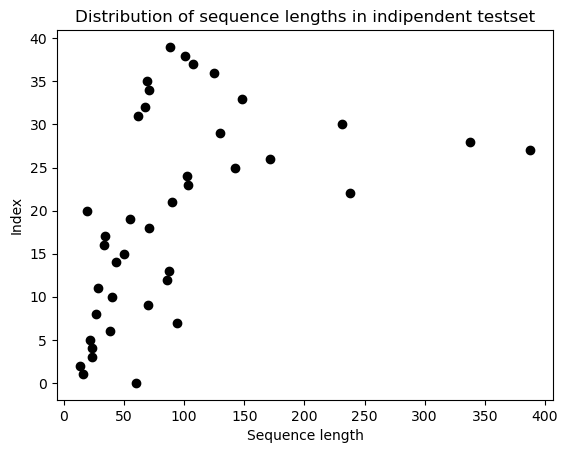

In [6]:
plotlengths('../Benchmark/testset.csv', 'Distribution of sequence lengths in indipendent testset')

In [ ]:
import os
from Bio.PDB import PDBParser
from Bio import SeqIO
from tqdm import tqdm

def pdb_to_fasta(directory_path, output_directory, fastaname):
    result = []
    seen_filenames = set()
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith(".ent"):
            parser = PDBParser()
            structure = parser.get_structure(filename, os.path.join(directory_path, filename))
            for model in structure:
                for chain in model:
                    seq = ""
                    for residue in chain:
                        res_id = residue.get_id()
                        if res_id[0] == " ":
                            seq += residue.get_resname().strip()
                    if filename not in seen_filenames:
                        seen_filenames.add(filename)
                        header = ">" + filename[3:] + " " + str(len(seq)) + "\n"
                        result.append(header + seq + "\n")
    result.sort()
    fasta_output = "".join(result)
    with open(os.path.join(output_directory, str(fastaname)), "w") as outfile:
        outfile.write(fasta_output)
    print("Fasta file genereted. OK")

pdb_to_fasta('./indepedents/', './', 'indepedents.fasta')


In [1]:
# Make json for independent testset
import json
from Bio import SeqIO

data = []
datacount = 0

fasta_file = "./indepedents.fasta"

for record in SeqIO.parse(fasta_file, "fasta"):
    datacount += 1
    code = record.id
    seq_and_dbn = str(record.seq).split("D") # D is a label / mark I put manually...
    sequence = seq_and_dbn[0]
    dbn = seq_and_dbn[1]
    sample = {'GeneralID': 'G' + str(datacount).zfill(2),
              'Sequence': sequence,
              'Length': len(sequence),
              'S_structure': dbn,
              'Dataset': 'independents',
              'InternalID': code[0:4].upper()}
    data.append(sample)

with open("indepedents.json", "w") as file:
    json.dump(data, file)

CONVERT DOTBRACKET TO LABELS FOR MULTI-CLASS CLASSIFICATION

In [17]:
import json 

with open('./redundants80_clean.json', 'r') as file:
    data = json.load(file)

In [21]:
from tqdm import tqdm

for rna in tqdm(data):
    label = rna['S_structure'].replace('.', '0').replace('(', '1').replace(')', '2').replace('[', '3').replace(']', '4')
    rna['Labels'] = label

100%|██████████| 5235/5235 [00:00<00:00, 758032.92it/s]


In [22]:
import json

with open("redundants80_labels.json", "w") as file:
    json.dump(data, file)

In [6]:
import json 

with open('./redundants80_for_dnabert_clean.json', 'r') as file:
    rnas = json.load(file)

all_bases = 0
count = 0 
for rna in rnas:
    count += 1
    all_bases += rna['Length']

print("Total number of sequences:", count)
print("Total number of bases:", all_bases)

pairs = all_bases * all_bases
print("Total number of pairs:", pairs)

print('0:', (pairs - 95)/100)

    

Total number of sequences: 16763
Total number of bases: 2217379
Total number of pairs: 4916769629641
0: 49167696295.46
